In [ ]:
# 8 STEP: CREATE DATAFRAME OF PUBLICATIONS
# In this Notebook, the dataframe we will work with for our analysis of gender equality
# will be created. For that, the publications and necessary info will be extracted from 'clean-dblp.xml'
# And completed with information on gender from 'names_cat.csv'

In [1]:
# >>> Import necessary data

# Import the publication data
import datetime
import xml.etree.ElementTree as ET
parser = ET.XMLParser()
    
file = 'data/clean_dblp.xml'

time = datetime.datetime.now()
print("Starting to parse XML file at {} ...".format(time))
tree = ET.parse(file, parser=parser)
time = datetime.datetime.now()
print("Finished parsing XML file at {} ! ".format(time))
root = tree.getroot()
print("Found {} entries! ".format(len(root)))

Starting to parse XML file at 2019-05-07 13:48:01.491708 ...
Finished parsing XML file at 2019-05-07 13:48:56.603749 ! 
Found 4544385 entries! 


In [2]:
# Import categorized 'names_cat.csv'
import pandas

print("Importing categorized names that were improved twice before... ")
names = pandas.read_csv("data/names_cat_i2.csv", usecols=["name", "n_publs", "likely_gender", "score"])

# Setting index & accessing cells: https://pythonhow.com/accessing-dataframe-columns-rows-and-cells/
names = names.set_index("name", drop = False)
print("Names imported. They look like this: {}".format(names[:10]))

Importing categorized names that were improved twice before... 
Names imported. They look like this:                                         name likely_gender  n_publs  score
name                                                                      
'Maseka Lesaoana            'Maseka Lesaoana        female        2      8
(David) Jing Dai            (David) Jing Dai          male        1      7
(Max) Zong-Ming Cheng  (Max) Zong-Ming Cheng          male        2      8
(Sophy) Shu-Jiun Chen  (Sophy) Shu-Jiun Chen        female        2      7
(Zhou) Bryan Bai            (Zhou) Bryan Bai          male        2      6
A Clara Kanmani              A Clara Kanmani        female        1      5
A Lun                                  A Lun          male        1      1
A Min Tjoa                        A Min Tjoa          male      211      2
A S Akshaya                      A S Akshaya          male        1      2
A'ang Subiyakto              A'ang Subiyakto        female        2      1

In [3]:
# >>> Set the min. reliable score (found out in last step)
score_min = 5
change_fact = score_min - 1

In [4]:
# >>> Create a dataset of adjusted scores 
# These will be used to try and find out which score is the most reliable
def adjust(score):
    if(score >= score_min):
        return score - change_fact # any score that is reliable is 1 or bigger
    else:
        return 0 # unreliable scores are all 0

adjusted_scores = []
for score in names['score']:
    adjusted_scores.append(adjust(score))

(array([1.050103e+06, 2.996150e+05, 2.066460e+05, 1.903210e+05,
        1.643920e+05, 1.432420e+05, 1.032490e+05, 6.018300e+04,
        3.538400e+04, 2.014300e+04, 1.105800e+04, 6.734000e+03,
        4.688000e+03, 4.094000e+03, 2.379000e+03, 1.174000e+03,
        6.560000e+02, 3.890000e+02, 5.540000e+02, 5.250000e+02,
        2.840000e+02, 1.490000e+02, 1.440000e+02, 9.200000e+01,
        1.010000e+02, 6.900000e+01, 3.700000e+01, 3.000000e+00,
        1.000000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.]),
 <a list of 29 Patch objects>)

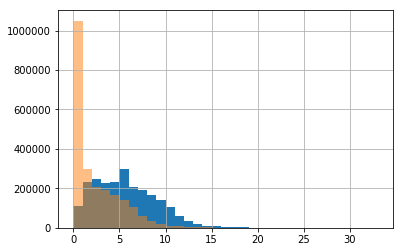

In [6]:
# Visualize adjusted scores
import matplotlib.pyplot as plt
names['score'].hist(bins=names['score'].max())
plt.hist(adjusted_scores, bins=max(adjusted_scores), alpha=0.5)

In [ ]:
# >>> Calc outliers 
# https://www.wikihow.com/Calculate-Outliers
'''n = names_scores_new
med = np.median(n)
higher =  np.percentile(n, 75)
lower =  np.percentile(n, 25)
interquart_range = higher - lower
inner_fence_higher = higher + interquart_range * 1.5
outer_fence_higher = higher + interquart_range * 3
print("For the adjusted scores, the inner fence is {}, the outer fence is {}".format(inner_fence_higher, outer_fence_higher))

inner_fence_lower = lower - interquart_range * 1.5
outer_fence_lower = lower -  interquart_range * 3
print("For the adjusted scores, the inner fence is {}, the outer fence is {}".format(inner_fence_lower, outer_fence_lower))'''

In [9]:
import numpy as np

# >>> Get all publications and fill with info

# Get all gender related info
# The gender inequality index r tells us how much equalizing would be needed so there is an equal amount of male and 
# female authors. For example, if there are 4 authors in total, and 3 are male, 1 would need to be female in order 
# for the ratio between man and women to be equal. 
# It is calculated like so: 50% (the half) - 25% (percentage of women) = 25% (inequality index)

higher =  np.percentile(adjusted_scores, 75)
score_max = higher + change_fact # calculate back TODO: Is this the right value to chose?
def get_gender_picture(n):
    "This function returns the amount of male, female and unknown authors as well as the gender inequality ratio (in %)"
    m_min = 0.0 #male
    m_max = 0.0
    f_min = 0.0 #female
    f_max = 0.0
    u = 0.0 #unknown
    r_min = 0.0 #inequality index
    r_max = 0.0
    for name in n:
        score = names.at[name, "score"]
        gender = names.at[name, "likely_gender"]
        if(score >= score_min):
            if(gender == "male"):
                m_max += 1.0
            elif(gender == "female"):
                f_max += 1.0
        if(score > score_max):
            if(gender == "male"):
                m_min += 1.0
            elif(gender == "female"):
                f_min += 1.0
    sm_total = len(n)
    
    sm_min = m_min + f_min #sum of male and female authors
    sm_max = m_max + f_max
    
    u_min = sm_total - sm_max
    u_max = sm_total - sm_min

    if(sm_max > 0):
        half_rel = 50
        
        f_rel_max = (f_min / sm_max) * 100 #relative amount of female authors
        r_max = half_rel - f_rel_max #inequality index
        if(sm_min > 0):
            f_rel_min = (f_min / sm_min) * 100 #relative amount of female authors
            r_min = half_rel - f_rel_min #inequality index
    return {
        'males': m_max,
        'females': f_max,
        'unknowns': u_min,
        'ratio': r_max,
        'males_min': m_min,
        'females_min': f_min,
        'unknowns_max': u_max,
        'ratio_min': r_min
    }

In [10]:
# Get all publications
publications_complete = {}

print("Starting to extract publications...")

for child in root:
    # Extract: key, category of publication, 
    key = child.get('key')
    pub_cat = child.tag
    
    # Optionally extract: title, year of publication, publtype, pages
    titles = child.findall("title")
    if(len(titles) > 0): title = titles[0].text
    
    years = child.findall("year")
    if(len(years) > 0): year = years[0].text
    
    pub_type = child.get('publtype')
    
    # Get authors
    authors = child.findall("author")
    
    current_names = []
    
    for author in authors:
        current_names.append(author.text)
    
    # Get gender info
    gender_pic = get_gender_picture(current_names)
    n_males = gender_pic['males']
    n_females = gender_pic['females']
    n_unknown = gender_pic['unknowns']
    ratio = gender_pic['ratio']
    n_males_min = gender_pic['males_min']
    n_females_min = gender_pic['females_min']
    n_unknown_max = gender_pic['unknowns_max']
    ratio_min = gender_pic['ratio_min']
    
    # Add publication entry
    publications_complete[key] = {
        'key': key,
        'pub_cat': pub_cat,
        'pub_type': pub_type,
        'title': title,
        'year': year,
        'authors': current_names,
        'n_authors': len(names),
        'n_males': n_males,
        'n_females': n_females,
        'n_unknown': n_unknown,
        'ratio': ratio,
        'n_males_min': n_males_min,
        'n_females_min': n_females_min,
        'n_unknown_max': n_unknown_max,
        'ratio_min': ratio_min
    }

print("Finished extracting publications and calculating all needed information! Found {} entries.".format(len(publications_complete)))

Starting to extract publications...
Finished extracting publications and calculating all needed information! Found 4544385 entries.


In [12]:
# >>> Convert results into dataframe
# Dict to dataframe: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html
print("Converting dictionary of publications to a dataframe...")
publications = pandas.DataFrame.from_dict(publications_complete, orient='index', dtype=None)
print("Dataframe completed! Here are some entries: {}".format(publications[:10]))

Converting dictionary of publications to a dataframe...
Dataframe completed! Here are some entries:                                                                    key  \
books/acm/0082477                                    books/acm/0082477   
books/acm/Kim95                                        books/acm/Kim95   
books/acm/kim95/AnnevelinkACFHK95    books/acm/kim95/AnnevelinkACFHK95   
books/acm/kim95/Blakeley95                  books/acm/kim95/Blakeley95   
books/acm/kim95/BreitbartGS95            books/acm/kim95/BreitbartGS95   
books/acm/kim95/BreitbartR95              books/acm/kim95/BreitbartR95   
books/acm/kim95/ChristodoulakisK95  books/acm/kim95/ChristodoulakisK95   
books/acm/kim95/DayalHW95                    books/acm/kim95/DayalHW95   
books/acm/kim95/DittrichD95                books/acm/kim95/DittrichD95   
books/acm/kim95/Garcia-MolinaH95      books/acm/kim95/Garcia-MolinaH95   

                                         pub_cat pub_type  \
books/acm/0082477       

In [13]:
# >>> Save results
# Save Dataframe to CSV: https://riptutorial.com/pandas/example/19502/create-random-dataframe-and-write-to--csv
print("Saving dataframe as CSV...")
publications.to_csv("data/publications_cor1.csv")
print("Publications saved as CSV!")

Saving dataframe as CSV...
Publications saved as CSV!
